We now need to create the final white light curve, taking into account the wavelength ranges we considered in #5, the resampling and the wavelength solution. We also need to standardize the ancillary data.

In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import reduction_utils.wavelength_calibration as wc

Define the contact points and wavelength range as used in notebook 5:

In [3]:
contact1 = 3
contact4 = 40

min_wvl = 4500
max_wvl = 9200

Load in the data:

In [4]:
parent_direc = '/Users/james/ACAMdata/hat44/20180326/reduction12/no_flat/'

star1_flux = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_flux_resampled.pickle','rb'))
star2_flux = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_flux_resampled.pickle','rb'))

error1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star1_error_resampled.pickle','rb'))
error2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/star2_error_resampled.pickle','rb'))

wvl_solution_1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/wavelength_solution.pickle','rb'))

am = pickle.load(open(parent_direc+'pickled_objects/airmass.pickle','rb'))

mjd = pickle.load(open(parent_direc+'pickled_objects/mjd_time.pickle','rb'))

exp_times = pickle.load(open(parent_direc+'pickled_objects/exposure_times.pickle','rb'))

xpos1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/xpos1_resampled.pickle','rb'))
sky1 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky1_resampled.pickle','rb'))
fwhm1 = pickle.load(open(parent_direc+'pickled_objects/fwhm_1.pickle','rb'))

xpos2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/xpos2_resampled.pickle','rb'))
sky2 = pickle.load(open(parent_direc+'pickled_objects/improved_resampling/sky2_resampled.pickle','rb'))
fwhm2 = pickle.load(open(parent_direc+'pickled_objects/fwhm_2.pickle','rb'))

Load in y shifts, as calculated from 3_spectra_resampling.ipynb

In [5]:
ypos1 = pickle.load(open('../ypos1.pickle','rb'))
ypos1_smooth = pickle.load(open('../ypos1_smooth.pickle','rb'))

ypos2 = pickle.load(open('../ypos2.pickle','rb'))
ypos2_smooth = pickle.load(open('../ypos2_smooth.pickle','rb'))


Define time as fractional days:

In [6]:
time = mjd - int(mjd[0])

Rescale sky for differing exposure times:

In [7]:
sky1 = np.array([i/j for i,j in zip(sky1,exp_times)])
sky2 = np.array([i/j for i,j in zip(sky2,exp_times)])

As before, remove frame 5 and cut at frame 84

In [8]:
star1_flux = np.vstack((star1_flux[:4],star1_flux[5:84]))
star2_flux = np.vstack((star2_flux[:4],star2_flux[5:84]))

error1 = np.vstack((error1[:4],error1[5:84]))
error2 = np.vstack((error2[:4],error2[5:84]))

mjd = np.hstack((mjd[:4],mjd[5:84]))

time = np.hstack((time[:4],time[5:84]))

exp_times = np.hstack((exp_times[:4],exp_times[5:84]))

sky1 = np.vstack((sky1[:4],sky1[5:84]))
sky2 = np.vstack((sky2[:4],sky2[5:84]))

xpos1 = np.vstack((xpos1[:4],xpos1[5:84]))
xpos2 = np.vstack((xpos2[:4],xpos2[5:84]))

fwhm1 = np.hstack((fwhm1[:4],fwhm1[5:84]))
fwhm2 = np.hstack((fwhm2[:4],fwhm2[5:84]))


ypos1 = np.hstack((ypos1[:4],ypos1[5:84]))
ypos2 = np.hstack((ypos2[:4],ypos2[5:84]))

ypos1_smooth = np.hstack((ypos1_smooth[:4],ypos1_smooth[5:84]))
ypos2_smooth = np.hstack((ypos2_smooth[:4],ypos2_smooth[5:84]))

am = np.hstack((am[:4],am[5:84]))

nframes = len(star1_flux)

Now cut only consider the wavelength range used for the spectroscopic light curves:

<IPython.core.display.Javascript object>


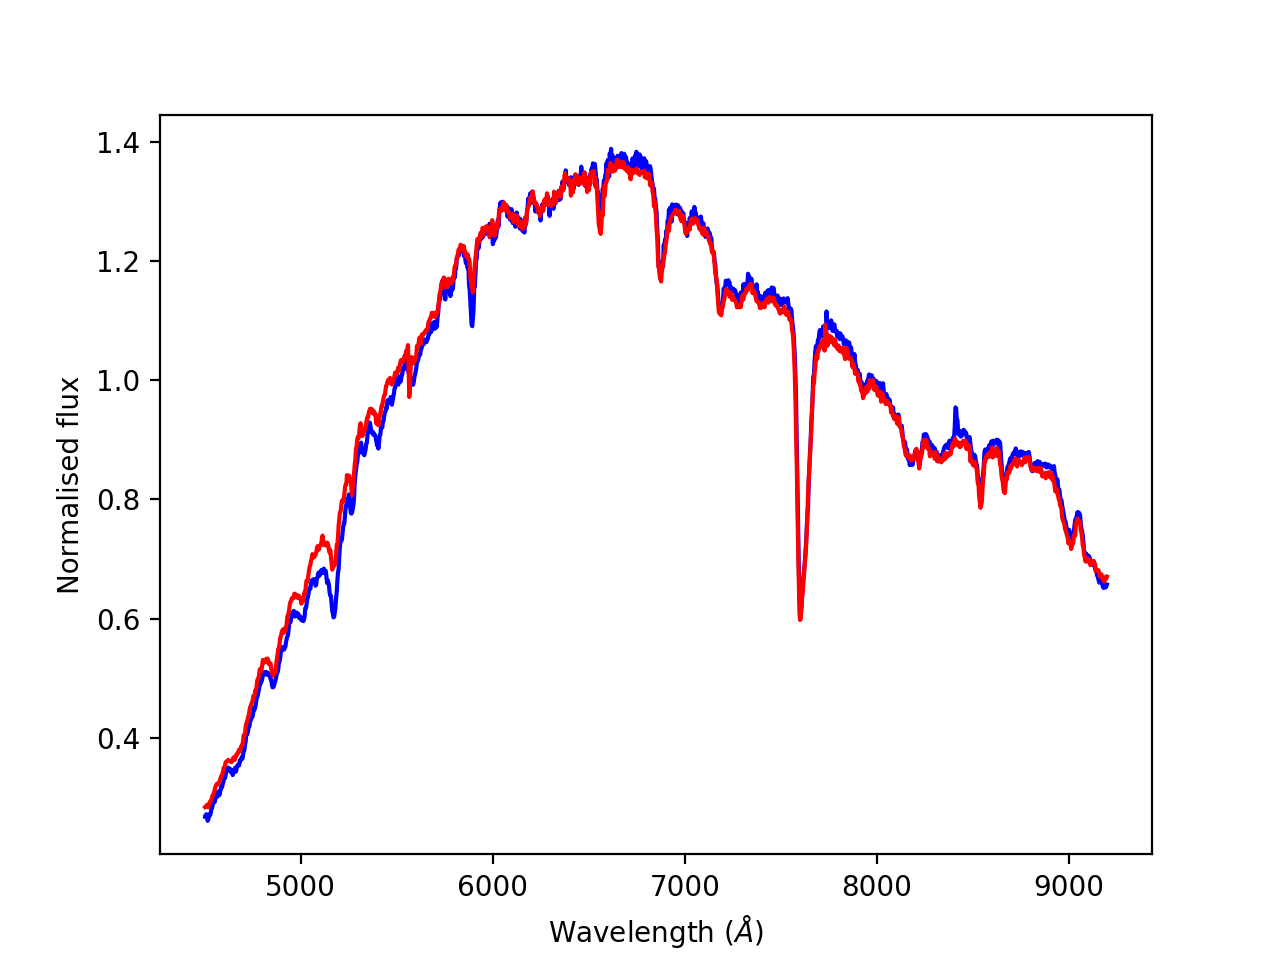

In [9]:
blue_mask = wvl_solution_1 < min_wvl
red_mask = wvl_solution_1 > max_wvl
combined_mask = blue_mask + red_mask

# Invert the mask
combined_mask = ~combined_mask


plt.figure()
plt.plot(wvl_solution_1[combined_mask],wc.normalise(star1_flux[nframes//2][combined_mask]),'b')
plt.plot(wvl_solution_1[combined_mask],wc.normalise(star2_flux[nframes//2][combined_mask]),'r')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised flux')
plt.show()

And perform the cut:

In [10]:
s1 = star1_flux[:,combined_mask]
s2 = star2_flux[:,combined_mask]

e1 = error1[:,combined_mask]
e2 = error2[:,combined_mask]

sky1 = sky1[:,combined_mask]
xpos1 = xpos1[:,combined_mask]

sky2 = sky2[:,combined_mask]
xpos2 = xpos2[:,combined_mask]

wvl = wvl_solution_1[combined_mask]

Now create the white light curve, normalise to the out of transit data and plot:

<IPython.core.display.Javascript object>


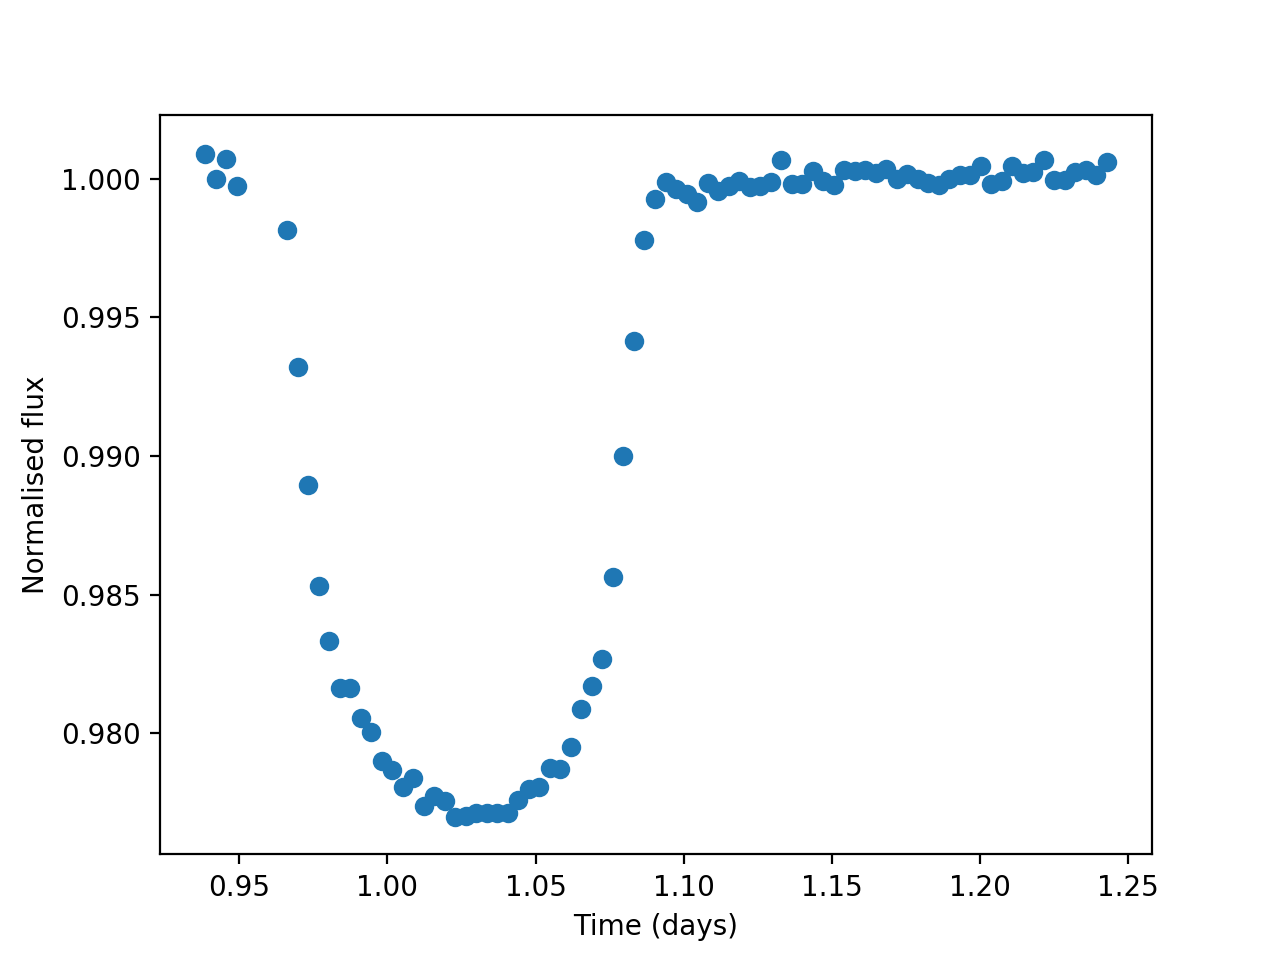

In [11]:
ratio = np.sum(s1,axis=1)/np.sum(s2,axis=1)
err_ratio = np.sqrt((np.sqrt(np.sum(e1**2,axis=1))/np.sum(s1,axis=1))**2 \
                    + (np.sqrt(np.sum(e2**2,axis=1))/np.sum(s2,axis=1))**2)*ratio


flux = ratio/np.median(ratio[:contact1].tolist()+ratio[contact4:].tolist())
error = (err_ratio/ratio) * flux

plt.figure()
plt.errorbar(time,flux,yerr=error,fmt='o',ecolor='k',capsize=0)
plt.ylabel('Normalised flux')
plt.xlabel('Time (days)')
plt.show()

And save the output:

In [12]:
# pickle.dump(flux,open('../pickled_objects/WL/white_light_flux.pickle','wb'))
# pickle.dump(error,open('../pickled_objects/WL/white_light_error.pickle','wb'))

Now combine and standardize the ancillary data for use in the fitting process.  This is done via subtracting the mean and dividing by the standard deviation.

<IPython.core.display.Javascript object>


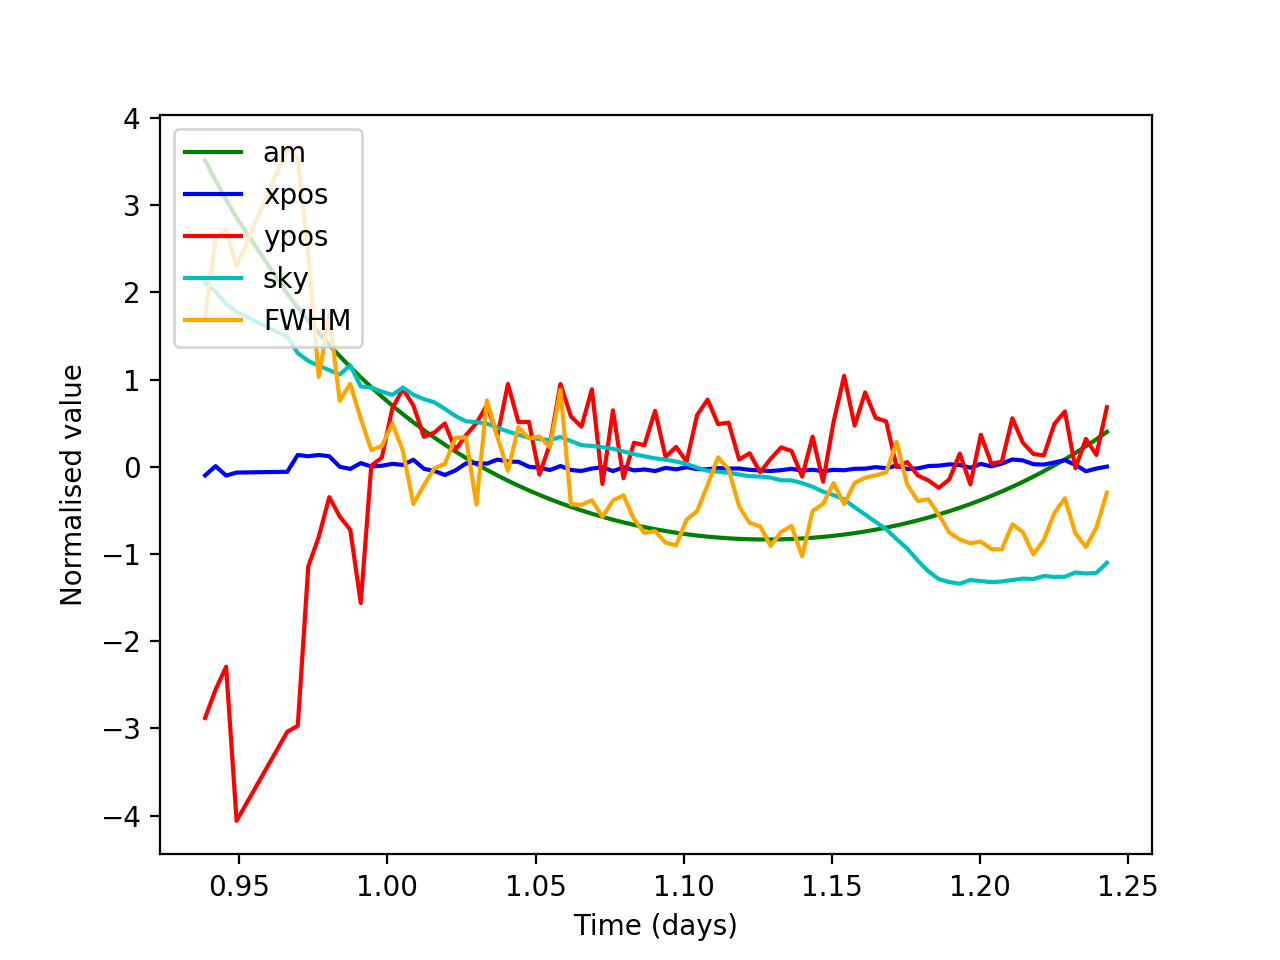

In [13]:

xpos1_norm = (xpos1.mean(axis=1)-xpos1.mean())/xpos1.std()
xpos2_norm = (xpos2.mean(axis=1)-xpos2.mean())/xpos2.std()

xpos = np.mean((xpos1_norm,xpos2_norm),axis=0)

ypos1_norm = (ypos1-ypos1.mean())/ypos1.std()
ypos2_norm = (ypos2-ypos2.mean())/ypos2.std()

# combine ypos into a single array from star 1 and star 2
ypos = np.mean((ypos1_norm,ypos2_norm),axis=0)


ypos1_smooth_norm = (ypos1_smooth-ypos1_smooth.mean())/ypos1_smooth.std()
ypos2_smooth_norm = (ypos2_smooth-ypos2_smooth.mean())/ypos2_smooth.std()

# combine ypos_smooth into a single array from star 1 and star 2
ypos_smooth  = np.mean((ypos1_smooth_norm,ypos2_smooth_norm),axis=0)



sky1_norm = (sky1.mean(axis=1)-sky1.mean())/sky1.std()
sky2_norm = (sky2.mean(axis=1)-sky2.mean())/sky2.std()

sky = np.mean((sky1_norm,sky2_norm),axis=0)

fwhm1_norm = (fwhm1-fwhm1.mean())/fwhm1.std()
fwhm2_norm = (fwhm2-fwhm2.mean())/fwhm2.std()

fwhm = np.mean((fwhm1_norm,fwhm2_norm),axis=0)

am_norm = (am-am.mean())/am.std()

plt.figure()
plt.plot(time,am_norm,'g',label='am')
plt.plot(time,xpos,'b',label='xpos')
plt.plot(time,ypos,'r',label='ypos')
plt.plot(time,ypos_smooth,'m',label='ypos_smooth')
plt.plot(time,sky,'c',label='sky')
plt.plot(time,fwhm,'orange',label='FWHM')
plt.xlabel('Time (days)')
plt.ylabel('Normalised value')
plt.legend(loc='upper left')
plt.show()
         

And save the output:

In [14]:
# pickle.dump(am_norm,open('../pickled_objects/am_norm.pickle','wb'))

# pickle.dump(fwhm,open('../pickled_objects/fwhm_norm.pickle','wb'))

# pickle.dump(sky,open('../pickled_objects/WL/sky_norm.pickle','wb'))

# pickle.dump(xpos,open('../pickled_objects/WL/xpos_norm.pickle','wb'))

# pickle.dump(ypos,open('../pickled_objects/ypos_norm.pickle','wb'))

# pickle.dump(ypos_smooth,open('../pickled_objects/ypos_smooth_norm.pickle','wb'))

# pickle.dump(time,open('../pickled_objects/time_norm.pickle','wb'))

We also want to calculate the central wavelength and wavelength range used for the white light curve to calculate the limb darkening coefficients.

In [15]:
wvl_centre = np.array([(max_wvl+min_wvl)//2])
wvl_error = np.array([max_wvl-min_wvl])

print(wvl_centre,wvl_error)


[6850] [4700]


And save:

In [16]:
# pickle.dump(wvl_centre,open('../pickled_objects/WL/white_wvl_centre.pickle','wb'))
# pickle.dump(wvl_error,open('../pickled_objects/WL/white_wvl_error.pickle','wb'))

Now we have spectroscopic and white light curves, we can fit the data!